In [1]:
#Importing libraries
import numpy as np
import pandas as pd

In [34]:
class GMM:
    #This class is the implementation of the Gaussian Mixture Models inspired by sci-kit learn implementation.
    def __init__(self, n_components, max_iter = 100, comp_names = None):
        '''
        :param n_components: int
            The number of clusters in which the algorithm must split the data set
        :param max_iter: int, default = 100
            The number of iteration that the algorithm will go through to find the clusters
        :param comp_names : list of strings, default = None
            In case it is setted as a list of string it will use to name the clusters
        '''
        self.n_components = n_components
        self.max_iter = max_iter
        if comp_names == None :
            self.comp_names = [f"comp{index}" for index in range( self.n_components)]
        else:
            self.comp_names = comp_names
        #pi list contains the fraction of the dataset for every cluster
        self.pi = [1/self.n_components for comp in range(self.n_components)]
    def multivariate_normal(self, X, mean_vector, covariance_matrix ):
        '''
        This function implements the multivariate normal derivation formula, the normal
        distribution for vectors 
        :param X: 1-d numpy array
            The row-vector for which we want to calculate the distribution
        :param mean_vector: 1-d numpy array
            The row-vector that contains the means for each column
        :param covariance_matriz: 2-d numpy array (matrix)
            The 2-d matrix that contain the covariances for the features
        '''
        return (2*np.pi)**(-len(X)/2)* np.linalg.det(covariance_matrix)**(-1/2)* np.exp(-np.dot(np.dot((X-mean_vector).T,
        np.linalg.inv(covariance_matrix)),(X-mean_vector ))/2)
    def fit(self, X):
        '''
            The function for training the model
        :param X: 2-d numpy array
            The data must be passed to the algorithm as 2–d array , where columns are the features and the rows are the samples
        '''
        #Spliting the data in n_componets sub-sets
        new_X = np.array_split (X, self.n_components)
        #Initial computation of the mean-vector and covarience matrix
        self.mean_vector = [np.mean(x, axis = 0) for x in new_X]
        self.covariance_matrixes = [np.cov (x.T) for x in new_X]
        #Deleting the new_X matrix because we will not need it anymore
        del new_X
        for iteration in range ( self.max_iter):
            #E-STEP
            # Initiating the r matrix, every row contains the probabilities for every cluster for this row
            self.r = np.zeros((len(X), self.n_components))
            # Calculating the r matrix
            for n in range(len(X)):
                for k in range( self.n_components):
                    self.r[n][k] = self.pi[k] * self.multivariate_normal (X[n], self.mean_vector[k], self.covariance_matrixes[k])
                    self.r[n][k] /= sum([self.pi[j] * self.multivariate_normal(X[n], self.mean_vector[j], self.covariance_matrixes[j])
                                         for j in range(self.n_components)])
            #Calculating the N
            N = np.sum(self.r, axis = 0)
            #M - STEP
            # Initializing the mean vector as a zero vector
            self.mean_vector = np.zeros((self.n_components, len(X[0])))
            # Updating the mean vector
            for k in range ( self.n_components):
                for n in range (len(X)):
                    self.mean_vector[k] += self.r[n][k] * X[n]
                    self.mean_vector = [1/N[k] * self.mean_vector[k]
                                        for k in range(self.n_components)]
            # Initiating the list of the covariance matrizes
            self.covariance_matrixes = [np.zeros((len(X[0]), len(X[0])))
                                         for k in range(self.n_components )]
            # Updating the covariance matrices
            for k in range(self.n_components):
                self.covariance_matrixes[k] = np.cov (X.T, aweights = (self.r[:, k]), ddof = 0)
            self.covariance_matrixes = [1/N[k]* self.covariance_matrixes[k]
                                        for k in range(self.n_components)]
            # Updating the pi list
            self.pi = [N[k]/len(X) for k in range(self.n_components)]
    def predict(self, X):
        '''
            The predicting function
        :param X: 2-d array numpy array
            The data on which we must predict the clusters
        '''

        probas = []
        for n in range(len(X)):
            probas.append([self.multivariate_normal(X[n], self.mean_vector [k], self.covariance_matrixes[k])
                                                    for k in range(self.n_components )])
        cluster = []
        for proba in probas:
            cluster.append(self.comp_names[proba.index(max(proba))])
        return cluster





In [14]:
#Sci-kit learn implimentation of GMM
#Importing libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse

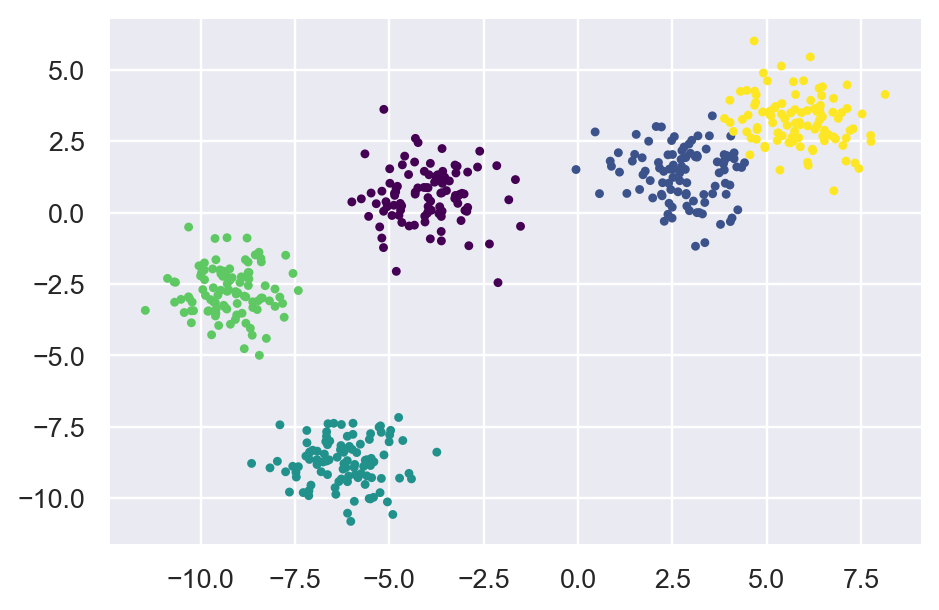

In [15]:
#Generating a random dataset with 500 samples and5 groups
X, y_true = make_blobs(n_samples = 500, centers = 5, cluster_std = 0.9, random_state = 17)
kmeans = KMeans(5, random_state = 420)
labels = kmeans.fit(X).predict(X)
plt.figure(dpi = 175)
plt.scatter(X[:, 0], X[:,1], c = labels, s = 7, cmap = 'viridis')

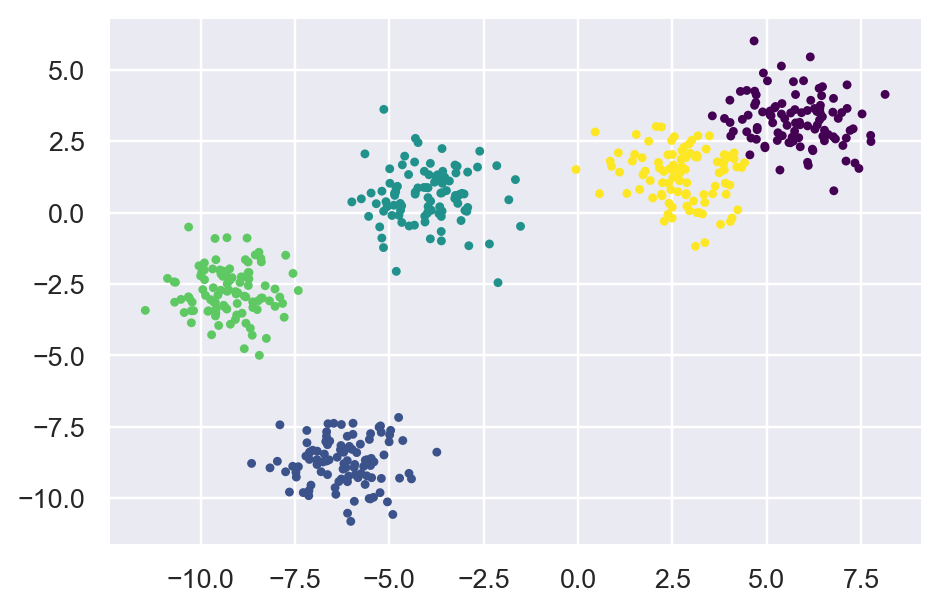

In [16]:
#Applying GMM algorithm
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 5).fit(X)
labels = gmm.predict(X)
plt.figure(dpi = 175)
plt.scatter(X[:, 0], X[:,1], c = labels, s = 7, cmap = 'viridis')

In [17]:
probabilities = gmm.predict_proba(X)

In [18]:
def plot_gmm(gmm, X, label = True, ax = None):
    def draw_ellipse(position, covariance, ax = None, **kwargs):
        ax = ax or plt.gca()
        if covariance.shape == (2,2):
            U, s, Vt = np.linalg.svd(covariance)
            angle = np.degrees(np.arctan2(U[1,0], U[0,0]))
            width, height = 2 * np.sqrt(s)
        else:
            angle = 0
            width, height = 2*np.sqrt(covariance)
        for nsig in range(1,4):
            ax.add_patch(Ellipse(position, nsig*width, nsig*height, angle, **kwargs))
        ax = ax or plt.gca()
        labels = gmm.fit(X).predict(X)
        if label:
            ax.scatter(X[:, 0], X[:,1], c = labels, s = 7, cmap = 'viridis')
        else:
            ax.scatter(X[:, 0], X[:,1],  s = 7, zorder = 2)
        ax.axis('equal')
        w_factor = 0.2 / gmm.weights_.max()
        for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
            draw_elipse(pos, covar, alpha = w * w_factor)

In [19]:
gmm = GaussianMixture(n_components=5, random_state=420)
plt.figure(dpi=175)
plot_gmm(gmm, X)

<Figure size 1050x700 with 0 Axes>

In [20]:
plt.figure(dpi=175)
plot_gmm(gmm, X)

<Figure size 1050x700 with 0 Axes>

In [21]:
#Dataset with a different shape
X, y_true = make_blobs(n_samples = 400, centers = 4, cluster_std = 0.6, random_state = 0)
#Flipping axes for better plotting
X = X[:, ::-1]
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))


In [22]:
#GMM algorithm
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plt.figure(dpi=175)
plot_gmm(gmm, X_stretched)

<Figure size 1050x700 with 0 Axes>

In [35]:
GMM = GMM(n_components=4)

In [36]:
GMM.fit(X)

c:\users\pulbe\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars


In [37]:
GMM.predict(X)

['comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
 'comp0',
